In [1]:
# Importing Libraries
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
%cd '/content/drive/MyDrive/Deep Learning/RNNs'

[WinError 3] The system cannot find the path specified: "'/content/drive/MyDrive/Deep Learning/RNNs'"
d:\Courses\ML\deep-learning-101\Model Zoo


In [4]:
# Loading Dataset
import string
import os
import unicodedata
import random

# parameters
alphabets = string.ascii_letters + " .,;'"
data_path = './data/names/'
total_chars = len(alphabets)

# some functions
def unicode_to_ascii(s):
  return ''.join(
      c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn'
      and c in alphabets
  )

def word_to_tensor(word):
  tensor = torch.zeros(len(word), 1, total_chars)
  for i, letter in enumerate(word):
    tensor[i][0][alphabets.find(letter)] = 1
  return tensor

def random_example(languages, data):
  language = random.choice(languages)
  language_tensor = torch.tensor([languages.index(language)])
  word = random.choice(data[language])
  return language_tensor, word_to_tensor(word)

# some functions
languages = []
data = {}
for file_name in os.listdir(data_path):
  category = file_name.split('.')[0]
  file = open(data_path+file_name, 'r')
  languages.append(category)
  data[category] = []
  for line in file.readlines():
    data[category].append(unicode_to_ascii(line))

UnicodeDecodeError: 'charmap' codec can't decode byte 0x81 in position 144: character maps to <undefined>

In [16]:
# Our RNN Model
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super().__init__()
    self.hidden_size = hidden_size
    self.i2h = nn.Linear(input_size+hidden_size, hidden_size)
    self.i2o = nn.Linear(input_size+hidden_size, output_size)
    self.softmax = nn.LogSoftmax(dim=1)
  
  def forward(self, input_tensor, hidden_tensor):
    combined = torch.cat((input_tensor, hidden_tensor), 1)
    hidden = self.i2h(combined)
    output = self.i2o(combined)
    output = self.softmax(output)
    return output, hidden
  
  def init_hidden(self):
    return torch.zeros(1, self.hidden_size)

In [17]:
# Initializing Models
device = 'cuda' if torch.cuda.is_available() else 'cpu'
input_size = len(alphabets)
output_size = len(languages)
hidden_size = 128
learning_rate = 0.005
iterations = 100000

rnn = RNN(input_size, hidden_size, output_size).to(device)
criterion = nn.NLLLoss()
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

In [18]:
losses = []
curr_loss = 0
for i in tqdm(range(iterations)):
  language, word = random_example(languages, data)
  hidden = rnn.init_hidden()
  for letter in word:
    output, hidden = rnn(letter, hidden)
  loss = criterion(output, language)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  losses.append(loss.item())

100%|██████████| 100000/100000 [02:11<00:00, 759.11it/s]


<function matplotlib.pyplot.show(*args, **kw)>

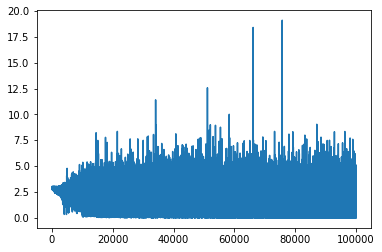

In [19]:
plt.figure()
plt.plot(losses)
plt.show

In [30]:
def predict(word):
  with torch.no_grad():
    word_tensor = word_to_tensor(word)
    hidden = rnn.init_hidden()
    for letter in word_tensor:
      output, hidden = rnn(letter, hidden)
    guess = torch.argmax(output)
    print(f'Word: {word}, Predicted: {languages[guess.item()]}')

In [52]:
predict('bukowski')

Word: bukowski, Predicted: Polish
